In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

#подгружаем данные
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/'
xy = pd.read_csv(os.path.join(data_dir, 'xy.csv'),sep=';')
xy.columns =['price_thousand', 'district', 'living_area', 'kitchen_area','full_area','n_rooms','plan','toilet','lodge','n_floors','floor','ceiling_h','house','design','year','time_walk_to_station','time_bus_to_station','station','n_stations_in_30_min','view']

Mounted at /content/drive


Обработка данных и EDA. У вас должны быть выводы о устройстве данных, например графики, которые показывают интересные взаимосвязи. 10 баллов

In [ ]:
#периодически используется профайл репорт
!pip install -U pandas-profiling
from pandas_profiling import ProfileReport

In [4]:
for col in xy:
    print(col,xy[col].unique())

price_thousand ['15000' '15900' '18500' ... '10890' '2660' '4000']
district ['центральный' 'северный' 'северо-восточный' 'восточный' 'юго-восточный'
 'южный' 'юго-западный' 'западный' 'северо-западный' 'зеленоградский'
 'новомосковский' 'троицкий']
living_area ['18' '18,5' '17' '52,5' '20' '21' '22,2' '19' '20,8' '16' '18,6' '19,1'
 '19,6' '17,5' '20,1' '29' '11' '13,1' '25' '33' '17,7' '15' '21,4' '22'
 '18,2' '21,3' '30' '18,8' '23' '12,8' '47' '11,3' '18,1' '28' '19,9'
 '19,3' '17,4' '17,1' '30,1' '31,9' '50' '43' '100' '32' '40' '110' '57,8'
 '31,6' '33,8' '32,1' '32,6' '36' '65' '35' '27' '34' '26,7' '41' '26,9'
 '76' '33,7' '80' '49' '44' '45' '35,2' '48' '32,4' '48,5' '86' '37'
 '63,1' '64,3' '42' '61,2' '30,8' '31,5' '54' '52' '120' '33,4' '38' '75'
 '87,7' '60' '53' '61' '150' '126' '84' '55' '69,1' '41,3' '93' '133,4'
 '57,1' '85' '105' '97,9' '95' '57' '73' '50,5' '74' '82' '81' '88' '2,4'
 '68' '71' '87' '37,6' '44,7' '160' '190' '42,3' '90' '70' '92,3' '64,4'
 '66' '50,8' 

In [ ]:
xy.describe()

n_rooms     n_floors         year  time_walk_to_station  \
count  3155.000000  3155.000000  3155.000000           3154.000000   
mean      2.010777    14.267195  1993.292868              9.490171   
std       0.819397     9.333254    24.290134              9.214472   
min       1.000000     0.000000  1866.000000              0.000000   
25%       1.000000     9.000000  1972.000000              4.000000   
50%       2.000000    12.000000  1999.000000              8.000000   
75%       3.000000    17.000000  2016.000000             14.000000   
max       3.000000    85.000000  2024.000000            180.000000   

       time_bus_to_station  n_stations_in_30_min  
count          3117.000000           3150.000000  
mean             10.108117              1.829841  
std              10.488220              1.122081  
min               0.000000              0.000000  
25%               4.000000              1.000000  
50%               6.000000              2.000000  
75%              10.000000              3.000000  
max              90.000000              4.000000

In [ ]:
xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_thousand        3155 non-null   object 
 1   district              3155 non-null   object 
 2   living_area           3155 non-null   object 
 3   kitchen_area          3155 non-null   object 
 4   full_area             3155 non-null   object 
 5   n_rooms               3155 non-null   int64  
 6   plan                  3155 non-null   object 
 7   toilet                3152 non-null   object 
 8   lodge                 3155 non-null   object 
 9   n_floors              3155 non-null   int64  
 10  floor                 3155 non-null   object 
 11  ceiling_h             3155 non-null   object 
 12  house                 3155 non-null   object 
 13  design                3155 non-null   object 
 14  year                  3155 non-null   int64  
 15  time_walk_to_station 

In [5]:
xy = xy.drop(index=2758) #drop потому что цена 66 тысяч

for index in [2090, 2456, 2494]:
    if ',' in xy.loc[index, 'price_thousand']:
        xy.loc[index, 'price_thousand'] = float(xy.loc[index, 'price_thousand'].replace(',', '.')) / 1000
mask = ~xy.index.isin([2090, 2456, 2494])
xy.loc[mask, 'price_thousand'] = xy.loc[mask, 'price_thousand'].astype(float) / 1000
xy = xy.rename(columns={'price_thousand': 'price_mil'})

xy['age'] = 2023 - xy['year']
xy.drop('year', axis=1, inplace=True)

xy['ceiling_h'] = xy['ceiling_h'].apply(lambda x: float(x.replace(',', '.')))

xy['kitchen_area'] = xy['kitchen_area'].apply(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

xy['living_area'] = xy['living_area'].apply(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

xy.loc[3087, 'full_area'] = float(xy.loc[3087, 'full_area'].replace('70,0/', '70.0'))
xy['full_area'] = xy['full_area'].apply(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

xy = xy.applymap(lambda x: x.lower() if isinstance(x, str) else x)

xy.loc[1204,'n_floors']=30

xy.loc[891,'age']=2

xy = xy.drop_duplicates()

xy.drop(index=xy[xy['full_area'] < xy['kitchen_area']].index, inplace=True)

xy.loc[2818,'ceiling_h']=3.0

In [ ]:
#заполнение пропусков руками оказалось эффективнее - пропускайте эту часть

In [ ]:
!pip install fancyimpute
from fancyimpute import KNN, NuclearNormMinimization, IterativeSVD

In [ ]:
cols = ["time_bus_to_station","time_walk_to_station"]
xy[cols] = xy[cols].replace({'0':np.nan, 0:np.nan})

In [ ]:
X_filled_knn = KNN(k=10).fit_transform(xy)
X_filled_IterativeSVD = IterativeSVD(rank=10).fit_transform(xy.values)

In [ ]:
pd.DataFrame(data=X_filled_knn,index=xy.index,columns=xy.columns)

In [ ]:
pd.DataFrame(data=X_filled_softimpute,index=xy.index,columns=xy.columns)

In [ ]:
pd.DataFrame(data=X_filled_IterativeSVD,index=xy.index,columns=xy.columns)

In [ ]:
#заполнение пропусков руками оказалось эффективнее

In [16]:
xy.loc[(xy['price_mil'] > 10) & (xy['price_mil'] < 12) & (xy['house'] == 'блочный')].groupby('toilet').toilet.count()

toilet
раздельный                  24
совмещённый                 41
совмещённый и раздельный     1
Name: toilet, dtype: int64

In [18]:
xy.loc[622,'toilet']='совмещённый'
xy.loc[685,'toilet']='раздельный'
xy.loc[690,'toilet']='совмещённый'

xy.loc[1654,'time_walk_to_station']=83.0

xy.loc[1654,'n_stations_in_30_min']=0.0
xy.loc[1835,'n_stations_in_30_min']=1
xy.loc[1872,'n_stations_in_30_min']=1
xy.loc[1876,'n_stations_in_30_min']=2
xy.loc[1890,'n_stations_in_30_min']=3

def fill_time_bus(row):
    bus_time=row['time_bus_to_station']
    if np.isnan(bus_time):
        station = row['station']
        district = row['district']
        walk_time = row['time_walk_to_station']
        if walk_time <= 10:
            return walk_time
        else:
            closest_time_walk = xy.loc[(xy['station']==station) & (xy['district']==district) & (~xy['time_bus_to_station'].isna()), 'time_walk_to_station'].values
            closest_time_bus = xy.loc[(xy['station']==station)& (xy['district']==district) & (xy['time_walk_to_station'] == closest_time_walk[np.argmin(np.abs(closest_time_walk-walk_time))]), 'time_bus_to_station'].values
            return closest_time_bus[0]
    else:
        return row['time_bus_to_station']

xy['time_bus_to_station'] = xy.apply(fill_time_bus, axis=1)

xy.loc[xy['time_bus_to_station']==0, 'time_bus_to_station']=xy.loc[xy['time_bus_to_station']==0, 'time_walk_to_station']

xy.loc[xy['time_walk_to_station']==0, 'time_walk_to_station']=xy.loc[xy['time_walk_to_station']==0, 'time_bus_to_station']*3

In [ ]:
xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3131 entries, 0 to 3154
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_mil             3131 non-null   float64
 1   district              3131 non-null   object 
 2   living_area           3131 non-null   float64
 3   kitchen_area          3131 non-null   float64
 4   full_area             3131 non-null   float64
 5   n_rooms               3131 non-null   int64  
 6   plan                  3131 non-null   object 
 7   toilet                3131 non-null   object 
 8   lodge                 3131 non-null   object 
 9   n_floors              3131 non-null   int64  
 10  floor                 3131 non-null   object 
 11  ceiling_h             3131 non-null   float64
 12  house                 3131 non-null   object 
 13  design                3131 non-null   object 
 14  time_walk_to_station  3131 non-null   float64
 15  time_bus_to_station  

In [ ]:
xy.describe()

price_mil  living_area  kitchen_area    full_area      n_rooms  \
count  3131.000000  3131.000000   3131.000000  3131.000000  3131.000000   
mean     21.485340    34.137838     10.892399    59.162721     2.007027   
std      23.997601    17.193293      5.558787    25.677405     0.819461   
min       1.500000     2.000000      1.000000     8.000000     1.000000   
25%      11.371500    20.000000      7.600000    39.000000     1.000000   
50%      15.100000    30.520000     10.000000    54.000000     2.000000   
75%      22.000000    43.500000     12.100000    74.000000     3.000000   
max     390.090000   190.000000     68.000000   272.200000     3.000000   

          n_floors    ceiling_h  time_walk_to_station  time_bus_to_station  \
count  3131.000000  3131.000000           3131.000000          3131.000000   
mean     14.267327     2.789508             23.791440            10.055573   
std       9.343827     0.256455             32.895152            10.438047   
min       1.000000     1.600000              1.000000             1.000000   
25%       9.000000     2.640000              7.000000             4.000000   
50%      12.000000     2.700000             11.000000             6.000000   
75%      17.000000     2.900000             20.000000            10.000000   
max      85.000000     6.000000            270.000000            90.000000   

       n_stations_in_30_min          age  
count           3131.000000  3131.000000  
mean               1.829767    29.730118  
std                1.121994    24.305214  
min                0.000000     1.000000  
25%                1.000000     7.000000  
50%                2.000000    24.000000  
75%                3.000000    51.000000  
max                4.000000   157.000000

In [ ]:
#Binary Encoder хуже OHE - пропускаем эту часть

In [ ]:
!pip install category_encoders
from category_encoders.binary import BinaryEncoder

In [ ]:
bn = BinaryEncoder()
encoded_df = bn.fit_transform(xy,cols=['view','design','house','floor','lodge','toilet','plan','district','station'])

In [ ]:
from google.colab.data_table import DataTable
DataTable.max_columns = 50

In [ ]:
corr = abs(encoded_df.corr())
corr

In [ ]:
encoded_df.drop(columns=['living_area','time_walk_to_station','n_rooms','plan_0','toilet_0','floor_0'], inplace=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(encoded_df.loc[:,encoded_df.columns != 'price_mil'], encoded_df['price_mil'], test_size=0.25, random_state=1)

In [ ]:
from sklearn.metrics import mean_squared_log_error
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
mean_squared_log_error(y_test.values, abs(np.array(y_pred)), squared=False)

In [ ]:
#Binary Encoder хуже OHE

In [ ]:
xy.groupby('lodge_balcony')['price_mil'].count()

In [24]:
# Create new columns and initialize them with 0
xy['house_p'] = 0
xy['house_m'] = 0
xy['house_b'] = 0

# Update the new columns based on the conditions
xy['house_p'] = xy['house'].apply(lambda x: 1 if 'панельн' in x else 1 if 'блочн' in x else 0)
xy['house_m'] = xy['house'].apply(lambda x: 1 if 'монолитн' in x else 0)
xy['house_b'] = xy['house'].apply(lambda x: 1 if 'кирпичн' in x else 1 if 'сталин' in x else 0)
xy.drop(columns='house',inplace=True)

# Create new columns and initialize them with 0
xy['lodge_balcony'] = 0
xy['lodge_lodge'] = 0
#xy['numerous_b'] = 0
#xy['numerous_l'] = 0

# Update the new columns based on the conditions
xy['lodge_balcony'] = xy['lodge'].apply(lambda x: 1 if 'балкон' in x else 0)
xy['lodge_lodge'] = xy['lodge'].apply(lambda x: 1 if 'лоджи' in x else 0)
#xy['numerous_b'] = xy['lodge'].apply(lambda x: 1 if 'более одного балкона' in x else 0)
#xy['numerous_l'] = xy['lodge'].apply(lambda x: 1 if 'более одной лоджии' in x else 0)
xy.drop(columns='lodge',inplace=True)

xy['toilet_sep'] = 0
xy['toilet_one'] = 0

# Update the new columns based on the conditions
xy['toilet_sep'] = xy['toilet'].apply(lambda x: 1 if 'раздельный' in x else 0)
xy['toilet_one'] = xy['toilet'].apply(lambda x: 1 if 'совмещённый' in x else 0)
xy.drop(columns='toilet',inplace=True)

xy['view_yard'] = 0
xy['view_street'] = 0

# Update the new columns based on the conditions
xy['view_yard'] = xy['view'].apply(lambda x: 1 if 'двор' in x else 0)
xy['view_street'] = xy['view'].apply(lambda x: 1 if 'улицу' in x else 0)
xy.drop(columns='view',inplace=True)

# Update the new columns based on the conditions
xy['plan'] = xy['plan'].apply(lambda x: 1 if 'изолированная' in x else 0)

In [ ]:
label_encoder = LabelEncoder()
xy['station'] = label_encoder.fit_transform(xy['station'])

xy['district'] = label_encoder.fit_transform(xy['district'])

In [29]:
encoder = OneHotEncoder()

In [30]:
encoded_values = encoder.fit_transform(xy[['design']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['design']),index=xy.index)
xy = pd.concat([xy.drop('design', axis=1), encoded_df], axis=1).drop(["design_без ремонта"], axis=1)

In [31]:
encoded_values = encoder.fit_transform(xy[['floor']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['floor']),index=xy.index)
xy = pd.concat([xy.drop('floor', axis=1), encoded_df], axis=1).drop(["floor_промежуточный"], axis=1)

In [ ]:
#смешанное кодирование оказалось эффективнее - пропускаем эту часть

In [ ]:
encoder = OneHotEncoder()
encoded_values = encoder.fit_transform(xy[['view']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['view']),index=xy.index)
xy = pd.concat([xy.drop('view', axis=1), encoded_df], axis=1).drop(["view_во двор и на улицу"], axis=1)

In [ ]:
encoded_values = encoder.fit_transform(xy[['house']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['house']),index=xy.index)
xy = pd.concat([xy.drop('house', axis=1), encoded_df], axis=1).drop(["house_кирпично-монолитный"], axis=1)

In [ ]:
encoded_values = encoder.fit_transform(xy[['lodge']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['lodge']),index=xy.index)
xy = pd.concat([xy.drop('lodge', axis=1), encoded_df], axis=1).drop(["lodge_нет"], axis=1)

In [ ]:
encoded_values = encoder.fit_transform(xy[['toilet']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['toilet']),index=xy.index)
xy = pd.concat([xy.drop('toilet', axis=1), encoded_df], axis=1).drop(["toilet_совмещённый и раздельный"], axis=1)

In [ ]:
encoded_values = encoder.fit_transform(xy[['plan']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['plan']),index=xy.index)
xy = pd.concat([xy.drop('plan', axis=1), encoded_df], axis=1).drop(["plan_евро"], axis=1)

In [30]:
encoded_values = encoder.fit_transform(xy[['station']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['station']),index=xy.index)
xy = pd.concat([xy.drop('station', axis=1), encoded_df], axis=1).drop(["station_полянка"], axis=1)

In [31]:
encoded_values = encoder.fit_transform(xy[['district']])
encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out(['district']),index=xy.index)
xy = pd.concat([xy.drop('district', axis=1), encoded_df], axis=1).drop(["district_центральный"], axis=1)

In [ ]:
#смешанное кодирование оказалось эффективнее

Несколько обученных моделей. Вы должны сравнить результаты разных моделей. Так же итоговый результат должен быть справедливым, например не подойдет оценка вашей модели на обучающем множестве. Крайне рекомендуется почитать про train, val и test и почему данные разделяют на 3 части. 10 баллов

In [34]:
np.random.seed(1)
# first, split into X_train, X_valid_test, y_train, y_valid_test
# `test_size=0.3` split into 70% and 30%
X_train, X_valid_test, y_train, y_valid_test = train_test_split(xy.drop(columns='price_mil'), xy['price_mil'], test_size=0.3)

# second, split into X_valid, X_test, y_valid, y_test
# `test_size=0.5` split into 50% and 50%. The original data set is 30%,
# so, it will split into 15% equally.
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5)

In [35]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [36]:
X_valid = pd.DataFrame(data=scaler.fit_transform(X_valid), index=X_valid.index, columns=X_valid.columns)
X_test = pd.DataFrame(data=scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

In [37]:
X_train.columns = ['district', 'living_area', 'kitchen_area', 'full_area', 'n_rooms', 'plan',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'house_panel','house_monolite', 'house_brick', 'balcony',
       'lodge', 'toilet_div', 'toilet_uni', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last']

In [ ]:
#другие варианты кодирования - пропускаем

In [ ]:
X_train.columns = ['living_area', 'kitchen_area', 'full_area', 'n_rooms', 'plan',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station', 'n_stations_in_30_min', 'age', 'house_panel','house_monolite', 'house_brick', 'balcony',
       'lodge', 'toilet_div', 'toilet_uni', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last','station_aviamotor', 'station_avtozavodskaya', 'station_academic', 'station_alexandrovsky_garden', 'station_alexeyevskaya', 'station_alma_atinskaya', 'station_altufevo', 'station_aminevskaya', 'station_andronovka', 'station_annino', 'station_arbatskaya', 'station_aeroport', 'station_babushkinskaya', 'station_bagrationovskaya', 'station_baltiyskaya', 'station_barricade', 'station_baumanskaya', 'station_begovaya', 'station_belokamennaya', 'station_belomorskaya', 'station_belorusskaya', 'station_belyaevo', 'station_beskudnikovo', 'station_bibirevo', 'station_borovitskaya', 'station_botanic_garden', 'station_bratislavskaya', 'station_bulvar_admiral_ushakov', 'station_bulvar_Dmitry_Donskoy', 'station_bulvar_rokossovsky', 'station_buninskaya_alley', 'station_butovo', 'station_varshavskaya', 'station_vdnh', 'station_vladykino', 'station_vodny_stadium', 'station_voykovskaya', 'station_volgogradsky_prospekt', 'station_volzhskaya', 'station_volokolamskaya', 'station_vorontsovskaya', 'station_vystavochnaya', 'station_vyhino', 'station_govorovo', 'station_davydkovo', 'station_degunino', 'station_delovy_center', 'station_depo', 'station_dinamo', 'station_dmitrovskaya', 'station_dobryninskaya', 'station_domodedovskaya', 'station_dostoyevskaya', 'station_dubrovka', 'station_zhd_bekasovo', 'station_zhd_varshavskaya', 'station_zhd_spring', 'station_zhd_kryukovo', 'station_zhd_rassudovo', 'station_zhulebino', 'station_zil', 'station_zorge', 'station_zyuzino', 'station_zyablikovo', 'station_izmailovskaya', 'station_caluzhskaya', 'station_cantemirovskaya', 'station_kakhovskaya', 'station_kashirskaya', 'station_kievskaya', 'station_kitai_gorod', 'station_kozhukhovskaya', 'station_kolomenskaya', 'station_communarka', 'station_commolskaya', 'station_konkovo', 'station_koptevo', 'station_krasnogvardeyskaya', 'station_krasnopresnenskaya', 'station_krasnoselskaya', 'station_krasny_gate', 'station_red_builder', 'station_cropotkinskaya', 'station_krylatskoye', 'station_krymskaya', 'station_cuzminki', 'station_cuntsevskaya', 'station_kurskaya', 'station_kuryanovo', 'station_kutuzovskaya', 'station_leninsky_prospekt', 'station_lermontovsky_prospekt', 'station_lefortovo', 'station_lianozovo', 'station_lobnya', 'station_lomonosovsky_prospekt', 'station_lubyanka', 'station_luzhniki', 'station_lukhmanovskaya', 'station_lyublino', 'station_marxist', 'station_mariina_grove', 'station_mariino', 'station_mayakovskaya', 'station_medvedkovo', 'station_international', 'station_mendeleevskaya', 'station_minskaya', 'station_mitino', 'station_michurinsky_prospekt', 'station_mnevniki', 'station_molodezhnaya', 'station_moskvorechye', 'station_myakinino', 'station_nagatinskaya', 'station_nagornaya', 'station_narodnoe_militia', 'station_nakhabino', 'station_nakhimovsky_prospekt', 'station_nekrasovka', 'station_nemchinovka', 'station_nizhorodskaya', 'station_novatorskaya', 'station_novogireevo', 'station_novodachnaya', 'station_novokosino', 'station_novokunetskaya', 'station_novoperedelkino', 'station_novoslobodskaya', 'station_novye_cheryomushki', 'station_ozernaya', 'station_okruzhnaya', 'station_okskaya', 'station_oktyabrskaya', 'station_oktyabrskoye_field', 'station_olkhovaya', 'station_orehovo', 'station_otradnoe', 'station_ohotny_row', 'station_paveletskaya', 'station_pavshino', 'station_panfilovskaya', 'station_park_of_culture', 'station_park_of_victory', 'station_penyagino', 'station_pervomayskaya', 'station_pererva', 'station_perovo', 'station_perovo_park', 'station_insko_razumovskaya', 'station_printers', 'station_pionerskaya', 'station_planernaya', 'ilyichs_station_place', 'station_podolsk', 'station_pokrovskoe', 'station_polezhaevskaya', 'station_prazhskaya', 'station_preobrazhenskaya_square', 'station_prokshino', 'station_proletarskaya', 'station_prospect_vernadsky', 'station_prospect_of_the_world', 'station_profoyuznaya', 'station_pushkinskaya', 'station_pyatnitskoe_highway', 'station_working_village', 'station_ramenki', 'station_rasskazovka', 'station_rechnoy_railway_station', 'station_rizhskaya', 'station_rimskaya', 'station_rostokino', 'station_rumyantsevo', 'station_ryazansky_prospekt', 'station_savelovskaya', 'station_salarevo', 'station_sviblovo', 'station_sevastopolskaya', 'station_seligerskaya', 'station_semenovskaya', 'station_serpukhovskaya', 'station_setun', 'station_slavyansky_boulevard', 'station_smolenskaya', 'station_sokol', 'station_sokolnaya_gora', 'station_sokolniki', 'station_solntsevo', 'station_spartak', 'station_sportnaya', 'station_sretensky_boulevard', 'station_stakhanovskaya', 'station_strogino', 'station_student', 'station_sukharevskaya', 'station_shodnenskaya', 'station_taganskaya', 'station_tverskaya', 'station_textilschiki', 'station_technopark', 'station_timiryazevskaya', 'station_tretyakovskaya', 'station_troparevo', 'station_trubnaya', 'station_tulskaya', 'station_tushinskaya', 'station_heat_mill', 'station_ugreshskaya', 'station_ulitsa_1905', 'station_ulitsa_akademika_yangel', 'station_ulitsa_gorchakova', 'station_ulitsa_dmitrievsky', 'station_ulitsa_Sergei_Eisenstein', 'station_ulitsa_skobelevskaya', 'station_university', 'station_filatov_meadow', 'station_filevsky_park', 'station_fili', 'station_fonvizinskaya', 'station_frunzenskaya', 'station_khovrino', 'station_horoshevo', 'station_tsaritsyno', 'station_tsvetnoy_boulevard', 'station_tska', 'station_cherkizovskaya', 'station_chertanovskaya', 'station_chekhovskaya', 'station_chistye_ponds', 'station_shabolovskaya', 'station_shelepikha', 'station_shipilovskaya', 'station_shosse_of_enthusiasts', 'station_shelkovskaya', 'station_scherbinka', 'station_schukinskaya', 'station_electrozavodskaya', 'station_yugo_vostochnaya', 'station_yugo_zapadnaya', 'station_yuzhnaya', 'station_asenevo', 'district_eastern', 'district_western', 'district_zelenogradsky', 'district_novomoskovsky', 'district_severny', 'district_severo_east', 'district_severo_west', 'district_troitsky', 'district_yugo_vostochny', 'district_yugo_zapadny', 'district_jugny']

In [ ]:
X_train.columns = ['district', 'living_area', 'kitchen_area', 'full_area', 'n_rooms',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last']

In [ ]:
X_train.columns = ['district', 'living_area', 'kitchen_area', 'full_area', 'n_rooms',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'view_yard',
       'view_street', 'design_designer', 'design_evro',
       'design_cosmetic', 'house_block', 'house_brick',
       'house_monolite', 'house_panel', 'house_stalinsky',
       'floor_first', 'floor_last', 'balcony',
       'balcony_plus_lodge', 'several_balconies',
       'several_lodges', 'lodge', 'toilet_divided',
       'toilet_combined', 'plan_isolated', 'plan_contiguous',
       'plan_contiguous-isolated']

In [ ]:
#другие варианты кодирования

In [38]:
X_valid.columns = X_train.columns
X_test.columns = X_train.columns

<Axes: >

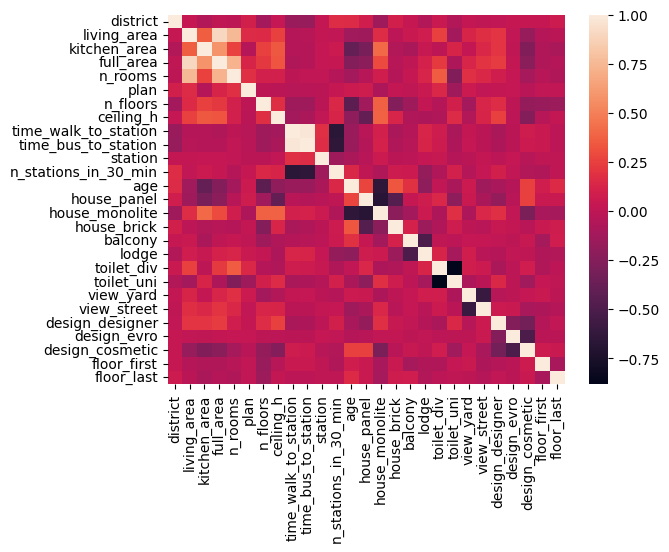

In [38]:
corr = X_train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [ ]:
from google.colab.data_table import DataTable
DataTable.max_columns = 50

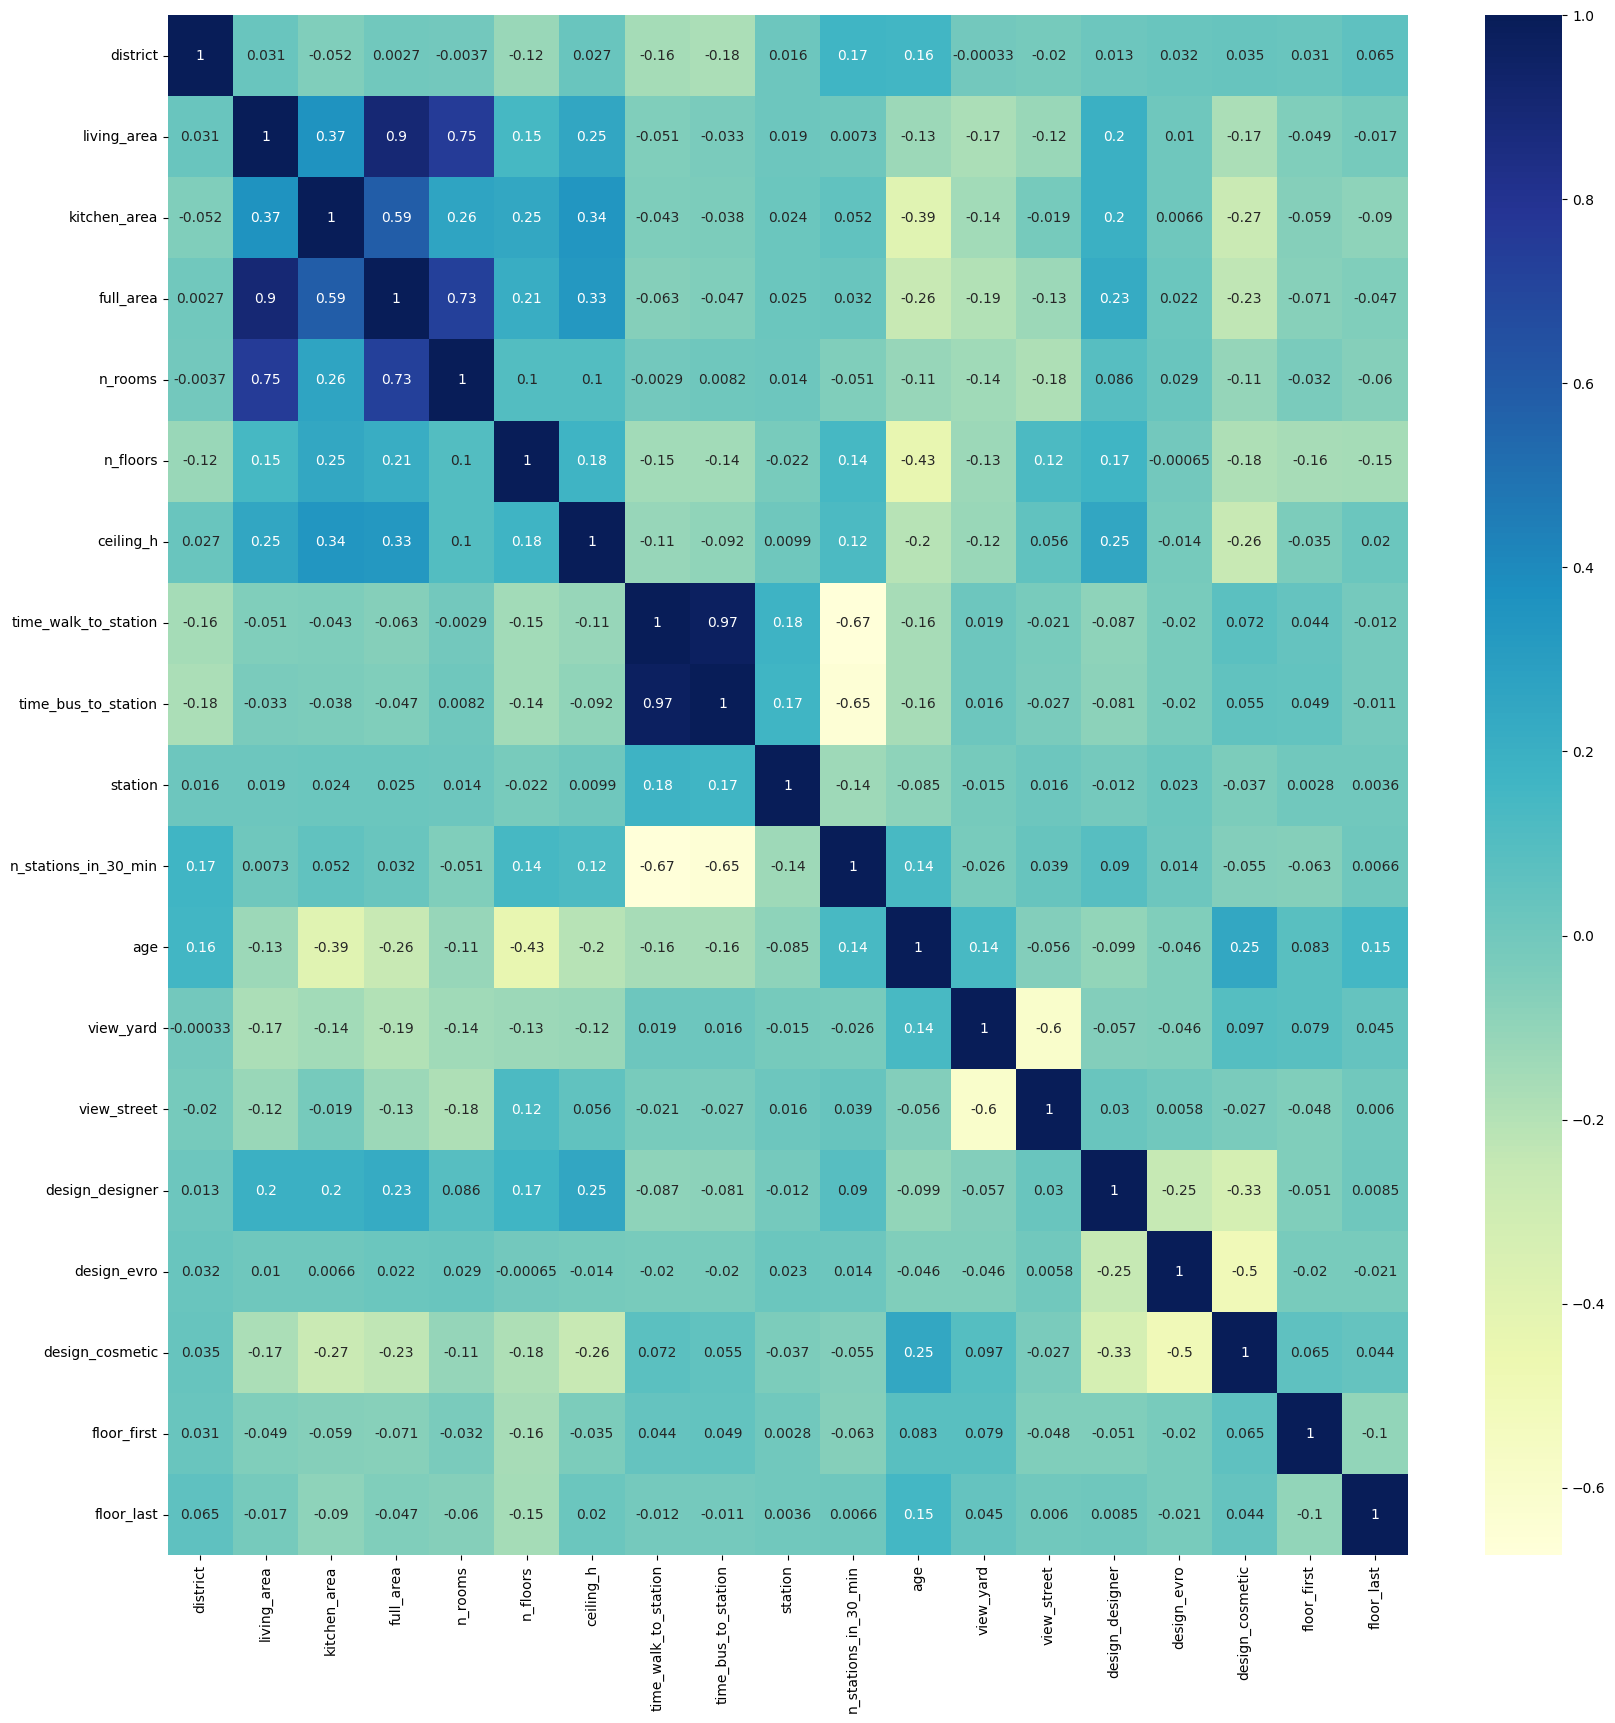

In [ ]:
plt.figure(figsize=(20, 20))
dataplot = sns.heatmap(X_train.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
#раньше я сразу удалял коррелянты, теперь нет - пропускаем

In [ ]:
X_train.drop(columns=['living_area','time_walk_to_station','n_rooms'], inplace=True)

In [ ]:
X_valid.drop(columns=['living_area','time_walk_to_station','n_rooms'], inplace=True)
X_test.drop(columns=['living_area','time_walk_to_station','n_rooms'], inplace=True)

In [ ]:
#раньше я сразу удалял коррелянты, теперь нет 

In [ ]:
X_train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

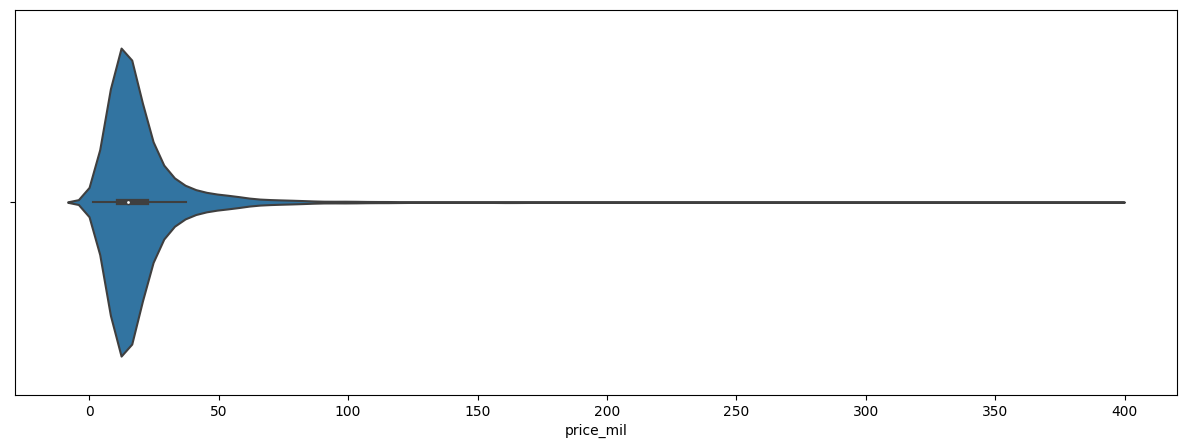

In [39]:
plt.figure(figsize=(15, 5))
sns.violinplot(x=y_train)
plt.show()

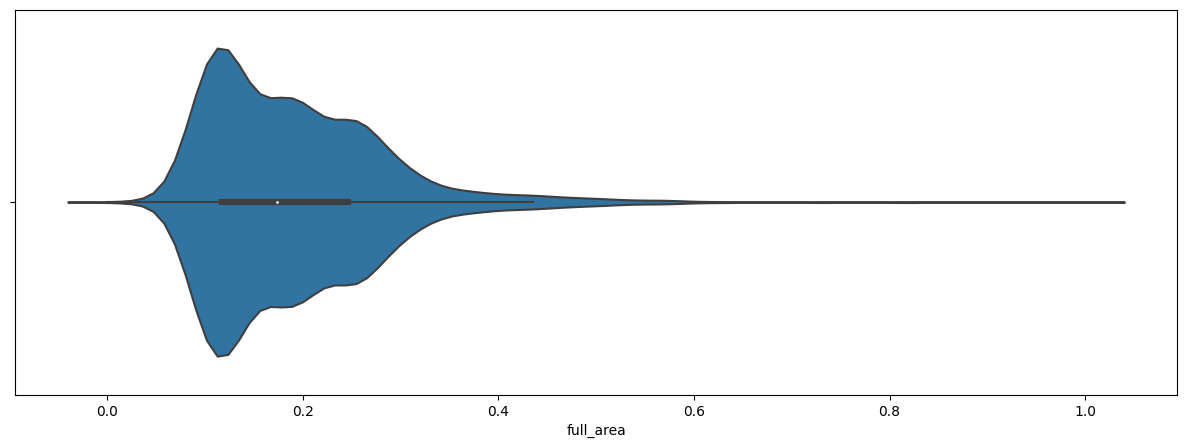

In [ ]:
plt.figure(figsize=(15, 5))
sns.violinplot(x=X_train['full_area'])
plt.show()

In [ ]:
#тут разные способы очистки от аномалий, но рабочий последний

<Axes: xlabel='time_bus_to_station', ylabel='full_area'>

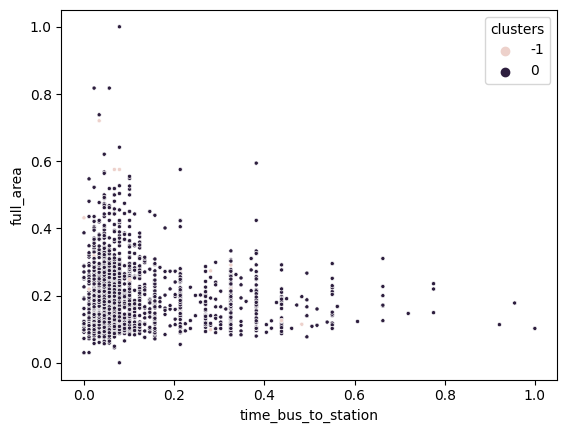

In [ ]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(eps = .2, metric='cosine', min_samples = 5, n_jobs = -1)
clusters = outlier_detection.fit_predict(X_train.loc[:,:'plan_contiguous-isolated'])
x_DBSCAN = pd.concat([X_train, pd.DataFrame(data=clusters,index=X_train.index,columns=['clusters'])], axis=1)
sns.scatterplot(data=x_DBSCAN, y="full_area", x="time_bus_to_station", hue='clusters',marker=".")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


<Axes: xlabel='time_bus_to_station', ylabel='full_area'>

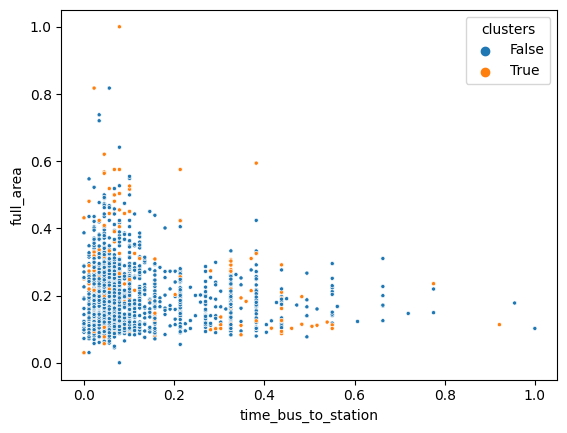

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100,random_state=1, contamination=.1) 
clf.fit(X_train)
if_scores = clf.decision_function(X_train)
if_anomalies=clf.predict(X_train)
if_anomalies=pd.Series(if_anomalies).replace([-1,1],[1,0])
if_anomalies=np.array([if_anomalies==1]);
x_forest = pd.concat([X_train, pd.DataFrame(data=if_anomalies.reshape(2191,1),index=X_train.index,columns=['clusters'])], axis=1)
sns.scatterplot(data=x_forest, y="full_area", x="time_bus_to_station", hue='clusters',marker=".")

<Axes: xlabel='time_bus_to_station', ylabel='full_area'>

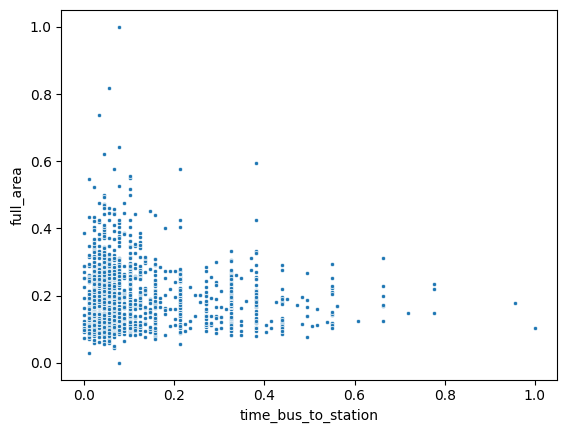

In [ ]:
for col in X_train.columns:
    # Calculate the quartiles and interquartile range for each column
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    iqr = q3 - q1
    
    # Calculate the upper and lower bounds for outliers
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    
    # Keep the inliers for each column
    x_simple = X_train[(X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)]
sns.scatterplot(data=x_simple, y="full_area", x="time_bus_to_station",marker=".")
#common_index = X_train.index.isin(x_simple.index)
#y_train = y_train[common_index]



Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f0192222830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


<Axes: xlabel='time_bus_to_station', ylabel='full_area'>

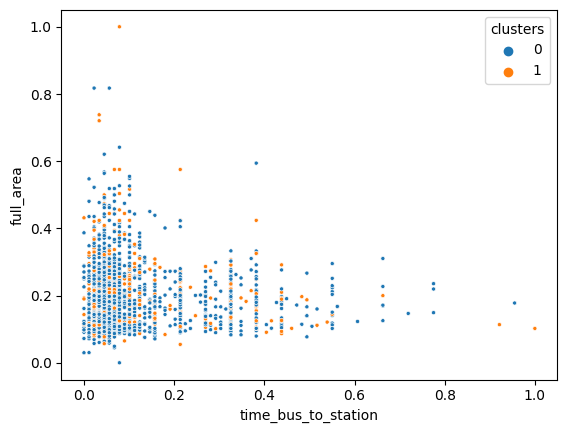

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=30, contamination=.2)
y_pred = clf.fit_predict(X_train)
LOF_Scores = clf.negative_outlier_factor_
LOF_pred = pd.Series(y_pred, index=X_train.index).replace([-1, 1], [1, 0])

x_LOF = pd.concat([X_train, pd.DataFrame(data=LOF_pred, index=X_train.index, columns=['clusters'])], axis=1)
sns.scatterplot(data=x_LOF, y="full_area", x="time_bus_to_station", hue='clusters', marker=".")

<Axes: xlabel='time_bus_to_station', ylabel='full_area'>

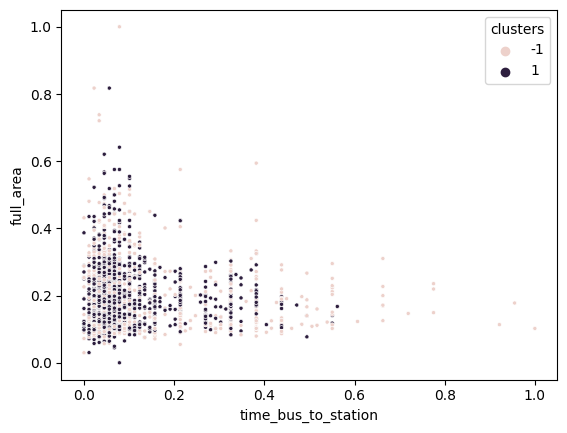

In [ ]:
from sklearn import svm
clf=svm.OneClassSVM(nu=.4,kernel='rbf',gamma=.001)
clf.fit(X_train)
y_pred=clf.predict(X_train)
x_svm = pd.concat([X_train, pd.DataFrame(data=y_pred, index=X_train.index, columns=['clusters'])], axis=1)
sns.scatterplot(data=x_svm, y="full_area", x="time_bus_to_station", hue='clusters', marker=".")

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-102.955336871836792 > -201.740944271501263). You may want to try with a higher value of support_fraction (current value: 0.508).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-104.174118920739190 > -172.775490814775054). You may want to try with a higher value of support_fraction (current value: 0.507).
  warnings.warn(


<Axes: xlabel='time_bus_to_station', ylabel='full_area'>

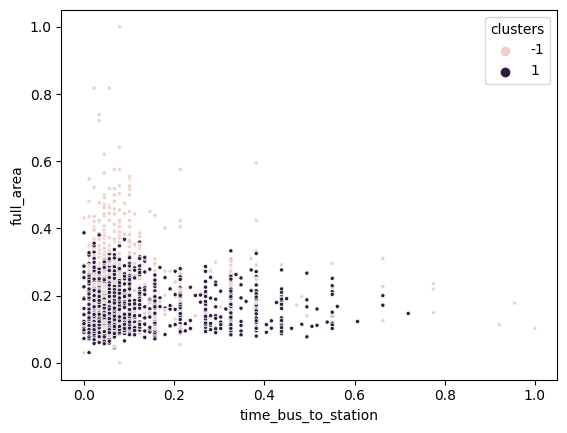

In [39]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope(contamination=.2,random_state=0)
clf.fit(X_train)
ee_scores = pd.Series(clf.decision_function(X_train)) 
ee_predict = clf.predict(X_train)
x_ee = pd.concat([X_train, pd.DataFrame(data=ee_predict, index=X_train.index, columns=['clusters'])], axis=1)
sns.scatterplot(data=x_ee, y="full_area", x="time_bus_to_station", hue='clusters', marker=".")

In [40]:
xxx=x_ee
xxx.drop(xxx[xxx['clusters']==-1].index, inplace=True)
common_index = y_train.index.isin(xxx.index)
yyy = y_train[common_index]
xxx.drop(columns=['clusters'], inplace=True)

sns.scatterplot(data=xxx, y="full_area", x="time_bus_to_station", marker=".")

In [ ]:
#Линейная регрессия

In [44]:
xxx.insert(0,'Y',yyy)
xxxyyy=xxx.copy(deep=True)
xxx.drop(columns='Y',inplace=True)

In [ ]:
#вариант 1

In [45]:
import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame named 'data' with columns 'district', 'x1', 'x2', ..., 'y'

# Group the data by district
xxxyyy.insert(0,'ones',1)
X_valid.insert(0,'ones',1)
grouped_data = xxxyyy.groupby('district')

# Dictionary to store the regression models for each district
models = {}

# Fit linear regression models for each district
for district, group in grouped_data:
    X = group[['ones','district', 'living_area', 'kitchen_area', 'full_area', 'n_rooms', 'plan',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'house_panel','house_monolite', 'house_brick', 'balcony',
       'lodge', 'toilet_div', 'toilet_uni', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last']]  # Independent variables for the current district
    y = group['Y']  # Dependent variable for the current district
    
    # Fit the linear regression model
    model = sm.OLS(y, X)  # Add constant term if needed
    result = model.fit()
    
    # Store the model for the current district
    models[district] = result

# Predict using the appropriate model for each district
predictions = []
for i, row in X_valid.iterrows():
    district = row['district']
    model = models[district]
    x_valid = row[['ones','district', 'living_area', 'kitchen_area', 'full_area', 'n_rooms', 'plan',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'house_panel','house_monolite', 'house_brick', 'balcony',
       'lodge', 'toilet_div', 'toilet_uni', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last']]  # Independent variables for the current test data

    # Make predictions using the corresponding model
    y_pred = model.predict(x_valid)  # Add constant term if needed
    predictions.append(y_pred)

# Combine the predictions into a single array or Series if needed
y_pred_combined = pd.concat(predictions)


In [84]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print(mean_squared_log_error(y_test.values, abs(np.array(y_pred_combined.values)), squared=False))
print(mean_squared_error(y_test.values, y_pred_combined.values, squared=False))
r2=r2_score(y_test.values, y_pred_combined.values)
print(1 - ( 1-r2 ) * ( len(y_pred_combined.values) - 1 ) / ( len(y_pred_combined.values) - xxx.shape[1] - 1 ))

0.5421168884213243
17.796391365792907
0.6013622688310123


In [ ]:
#вариант 2

In [78]:
from statsmodels.formula.api import ols

def forward_selected(data, response):
    remaining = set(data.columns) 
    remaining.remove(response)
    selected = []
    currentScore, bestNewScore = 0.0, 0.0
    while remaining and currentScore == bestNewScore: 
        scoresWithCandidates = []
        for candidate in remaining:
            score = ols(formula="{} ~ {}".format(response, ' + '\
            .join(selected + [candidate])), data=data).fit().rsquared_adj
            scoresWithCandidates.append((score, candidate)) 
        scoresWithCandidates.sort()
        bestNewScore, bestCandidate = scoresWithCandidates.pop()
        if currentScore <= bestNewScore: 
            remaining.remove(bestCandidate)
            selected.append(bestCandidate)
            currentScore = bestNewScore
    return ols(formula="{} ~ {}".format(response, ' + '.join(sorted(selected))), data=data).fit(cov_type='HC1').get_robustcov_results()

In [ ]:
xxxyyy.drop(columns='ones',inplace=True)
X_valid.drop(columns='ones',inplace=True)

In [83]:
import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame named 'data' with columns 'district', 'x1', 'x2', ..., 'y'

# Group the data by district

grouped_data = xxxyyy.groupby('district')

# Dictionary to store the regression models for each district
models = {}

# Fit linear regression models for each district
for district, group in grouped_data:
    X = group[['living_area', 'kitchen_area', 'full_area', 'n_rooms', 'plan',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'house_panel','house_monolite', 'house_brick', 'balcony',
       'lodge', 'toilet_div', 'toilet_uni', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last','Y']]  # Independent variables for the current district
    
    # Fit the linear regression model
    result = forward_selected(X,'Y')  # Add constant term if needed
    result.bse
    
    # Store the model for the current district
    models[district] = result

# Predict using the appropriate model for each district
predictions = []
for i, row in X_test.iterrows():
    district = row['district']
    model = models[district]
    x_test = row[['living_area', 'kitchen_area', 'full_area', 'n_rooms', 'plan',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'house_panel','house_monolite', 'house_brick', 'balcony',
       'lodge', 'toilet_div', 'toilet_uni', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last']]  # Independent variables for the current test data

    # Make predictions using the corresponding model
    y_pred = model.predict(x_test)  # Add constant term if needed
    predictions.append(y_pred)

# Combine the predictions into a single array or Series if needed
y_pred_combined = pd.concat(predictions)


In [ ]:
#вариант 3 (с катбуст - не советую запускать, работает 4 часа)

In [44]:
!pip install catboost
from catboost import CatBoostRegressor
grid = {'bootstrap_type':['Bayesian', 'Bernoulli', 'MVS', 'No','Poisson'],'depth':[8,10],'min_data_in_leaf':[1,3]}
model = CatBoostRegressor(iterations=1000, task_type='GPU', used_ram_limit='14GB')

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame named 'data' with columns 'district', 'x1', 'x2', ..., 'y'

# Group the data by district

grouped_data = xxxyyy.groupby('district')

# Dictionary to store the regression models for each district
models = {}

# Fit linear regression models for each district
for district, group in grouped_data:
    X = group[['district', 'living_area', 'kitchen_area', 'full_area', 'n_rooms', 'plan',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'house_panel','house_monolite', 'house_brick', 'balcony',
       'lodge', 'toilet_div', 'toilet_uni', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last']]  # Independent variables for the current district
    y = group['Y']  # Dependent variable for the current district
    
    # Fit the linear regression model
    model = CatBoostRegressor(iterations=1000,learning_rate=0.03, task_type='GPU', used_ram_limit='14GB')
    grid_search_result = model.grid_search(grid, X, y,verbose=False)
    #model.fit(X, y,verbose=False)
    
    # Store the model for the current district
    models[district] = model

# Predict using the appropriate model for each district
predictions = []
for i, row in X_valid.iterrows():
    district = row['district']
    model = models[district]
    x_valid = row[['district', 'living_area', 'kitchen_area', 'full_area', 'n_rooms', 'plan',
       'n_floors', 'ceiling_h', 'time_walk_to_station', 'time_bus_to_station',
       'station', 'n_stations_in_30_min', 'age', 'house_panel','house_monolite', 'house_brick', 'balcony',
       'lodge', 'toilet_div', 'toilet_uni', 'view_yard', 'view_street', 'design_designer', 'design_evro',
       'design_cosmetic','floor_first', 'floor_last']]  # Independent variables for the current test data

    # Make predictions using the corresponding model
    y_pred = model.predict(x_valid)  # Add constant term if needed
    predictions.append(y_pred)

# Combine the predictions into a single array or Series if needed


In [52]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print(mean_squared_log_error(y_valid.values, abs(np.array(predictions)), squared=False))
print(mean_squared_error(y_valid.values, predictions, squared=False))
r2=r2_score(y_valid.values, predictions)
print(1 - ( 1-r2 ) * ( len(predictions) - 1 ) / ( len(predictions) - xxx.shape[1] - 1 ))

0.35758809964195115
19.851735849642942
0.25168000151630965


In [ ]:
#самая простая линейная регрессия

In [ ]:
from sklearn.metrics import mean_squared_log_error
lr = LinearRegression()
lr.fit(xxx, yyy)
y_pred = lr.predict(X_valid)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print(mean_squared_log_error(y_valid.values, abs(np.array(y_pred)), squared=False))
print(mean_squared_error(y_valid.values, y_pred, squared=False))
r2=r2_score(y_valid.values, y_pred)
print(1 - ( 1-r2 ) * ( len(y_pred) - 1 ) / ( len(y_pred) - xxx.shape[1] - 1 ))

0.5327641849683153
18.00049757843063
0.3847389863779185


In [ ]:
#результаты разных линейных регрессий

In [ ]:
#ручная замена OHE с очисткой
0.5773089910720175
18.914908283409982
0.32522169024330894
#ручная замена без удаления коррелянтов
0.5746624165110923
18.81107505810347
0.32807993733270224
#устранение мультиколлинеарности
0.5754962490577383
18.80718358869519
0.3283579103780201
#разделение дистрикта и станции
0.4408494416754916
16.194783623666474
-0.15246986424268405
#без гетероскедастичности по потолкам
0.5419910911512863
18.07607678605905
0.37956151146546124
#создание системы
0.4057931329468848
15.60624186023248
0.5364776044289977
#устранение мультиколлинеарности + система
0.389352083042028
14.89508757682468
0.578714513038866
#Убираем гетероскедастичность + система
0.38935208781543873
14.895087606677404
0.5787145113501858
#На test выборке
0.5421168884213243
17.796391365792907
0.6013622688310123

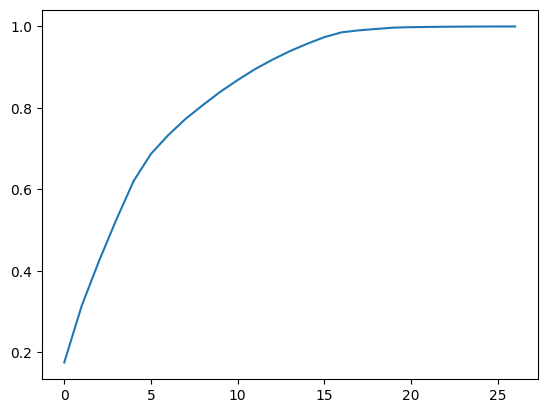

In [ ]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=xxx.shape[1])
X_train_scaled = xxx
pca_test.fit(X_train_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.show()

In [ ]:
#куски кода про отдельное устранение гетероскедастичности, мультиколлинеарности и проверки на автокорреляцию - можно пропустить

In [ ]:
#убираем мультиколлинеарность

In [ ]:
formula = "{} ~ {}".format('Y', ' + '.join(xxx.columns.tolist()))
formula

'Y ~ district + living_area + kitchen_area + full_area + n_rooms + plan + n_floors + ceiling_h + time_walk_to_station + time_bus_to_station + station + n_stations_in_30_min + age + house_panel + house_monolite + house_brick + balcony + lodge + toilet_div + toilet_uni + view_yard + view_street + design_designer + design_evro + design_cosmetic + floor_first + floor_last'

In [ ]:
xxx.insert(0,'Y',yyy)

In [ ]:
xxxyyy=xxx.copy(deep=True)
xxx.drop(columns='Y',inplace=True)

In [ ]:
from statsmodels.formula.api import ols
model = ols(formula=formula, data=xxxyyy).fit()
model.summary()

In [ ]:
from numpy import arange
from scipy.stats import norm, kstest
plt.figure(figsize=(16, 9))
histData = plt.hist(model.resid)
range_ = arange(min(model.resid), max(model.resid), 1)
coefY = len(model.resid) * (histData[1][1] - histData[1][0])
plt.plot(range_, [norm(model.resid.mean(), model.resid.std()).pdf(x) * coefY for x in range_], color='r')
plt.xticks(histData[1])
plt.grid()
plt.xlabel("Category (upper limits)", fontsize=15)
plt.ylabel("№ of observations", fontsize=15)
KS_maxD, KS_PValue = kstest(model.resid, cdf='norm', args=(model.resid.mean(), model.resid.std()))
plt.title("Histogram of the distribution of regression residuals\n"+
          "Distribution: Normal\n"+
          "Kolmogorov-Smirnov test = {:.5}, p-value = {:.5}".format(KS_maxD, KS_PValue),fontsize=15)
plt.show()

In [ ]:
from statsmodels.formula.api import ols

def forward_selected(data, response):
    remaining = set(data.columns) 
    remaining.remove(response)
    selected = []
    currentScore, bestNewScore = 0.0, 0.0
    while remaining and currentScore == bestNewScore: 
        scoresWithCandidates = []
        for candidate in remaining:
            score = ols(formula="{} ~ {}".format(response, ' + '\
            .join(selected + [candidate])), data=data).fit().rsquared_adj
            scoresWithCandidates.append((score, candidate)) 
        scoresWithCandidates.sort()
        bestNewScore, bestCandidate = scoresWithCandidates.pop()
        if currentScore <= bestNewScore: 
            remaining.remove(bestCandidate)
            selected.append(bestCandidate)
            currentScore = bestNewScore
    return ols(formula="{} ~ {}".format(response, ' + '.join(sorted(selected))), data=data).fit()

forwardModel = forward_selected(xxxyyy, 'Y')
forwardModel.summary()
y_pred = forwardModel.predict(X_valid)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     147.1
Date:                Sat, 20 May 2023   Prob (F-statistic):               0.00
Time:                        13:52:25   Log-Likelihood:                -5248.6
No. Observations:                1752   AIC:                         1.054e+04
Df Residuals:                    1732   BIC:                         1.065e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -14.1398      1.343    -10.528      0.000     -16.774     -11.506
age                      9.4858      1.153      8.229      0.000       7.225      11.747
balcony                 -0.3685      0.296     -1.244      0.214      -0.949       0.212
ceiling_h               44.0272      3.933     11.195      0.000      36.314      51.741
design_designer          3.0443      0.415      7.336      0.000       2.230       3.858
design_evro              0.6869      0.267      2.574      0.010       0.164       1.210
floor_first             -1.4797      0.471     -3.141      0.002      -2.404      -0.556
floor_last              -0.6308      0.374     -1.686      0.092      -1.365       0.103
full_area               61.0265      7.117      8.574      0.000      47.067      74.986
house_panel             -1.7635      0.266     -6.632      0.000      -2.285      -1.242
kitchen_area            15.3160      4.337      3.531      0.000       6.809      23.823
living_area             13.1690      6.986      1.885      0.060      -0.532      26.870
lodge                   -1.0419      0.309     -3.376      0.001      -1.647      -0.437
n_floors                12.8542      1.812      7.095      0.000       9.301      16.407
n_rooms                 -1.4869      0.697     -2.132      0.033      -2.855      -0.119
n_stations_in_30_min     4.1337      0.587      7.046      0.000       2.983       5.284
plan                     0.6368      0.411      1.550      0.121      -0.169       1.443
time_walk_to_station    -8.1297      1.401     -5.803      0.000     -10.877      -5.382
toilet_uni               0.9018      0.260      3.470      0.001       0.392       1.411
view_street              0.2889      0.239      1.211      0.226      -0.179       0.757
==============================================================================
Omnibus:                      751.544   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6189.973
Skew:                           1.805   Prob(JB):                         0.00
Kurtosis:                      11.472   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#проверяем гетероскедастичность и автокорреляцию

In [ ]:
xxxyyy.drop(columns=['district','time_bus_to_station','station','house_monolite','house_brick','toilet_div','view_yard','design_cosmetic'],inplace=True)

In [ ]:
X_valid.drop(columns=['district','time_bus_to_station','station','house_monolite','house_brick','toilet_div','view_yard','design_cosmetic'],inplace=True)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(forwardModel.resid)

2.064136369172894

In [ ]:
import scipy, scipy.stats
from statsmodels.stats.api import het_goldfeldquandt
for column in xxxyyy.drop(columns='Y').columns:
  p=scipy.stats.spearmanr(forwardModel.resid, xxxyyy[[column]])[1]
  if p<0.05:
    print(column,'p = ',p)

living_area p =  0.004352622222196373
kitchen_area p =  5.005653938993337e-10
full_area p =  8.789370283503863e-06
n_rooms p =  0.009838775218125494
n_floors p =  0.002332075133801249
ceiling_h p =  3.743282280587085e-17
n_stations_in_30_min p =  0.010002127250149689
age p =  0.004138229698663863
house_panel p =  5.088377475305557e-05


In [ ]:
from scipy.stats import f
from statsmodels.compat import lzip
def het_gq(y, x):
    nobs, nvar = x.shape
    sizeSubsample = nobs // 4
    fval, _, _ = het_goldfeldquandt(y=y, x=x, idx=0, split=sizeSubsample, drop=nobs - 2 * sizeSubsample)
    if fval < 1.0:
        fval = 1.0 / fval
    return (fval, f.ppf(q=0.95, dfn=sizeSubsample - nvar-1, dfd=sizeSubsample - nvar-1))

In [ ]:
name = ['F statistic', 'F crit']
for column in xxxyyy.drop(columns='Y').columns:
  p=het_gq(y=xxxyyy['Y'], x=xxx[[column]])
  if p[1]<p[0]:
    print(column,p)

In [ ]:
#убираем гетероскедастичность

In [ ]:
xxxyyy.insert(1,'ones',1)

In [ ]:
xxx_valid=X_valid
xxx_valid.insert(1,'ones',1)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Create a DataFrame with original variables
x=xxxyyy.drop(columns='Y')
y=yyy

# Define a list of transformations to apply
transformations = [
    ('Original', None),
    ('Logarithm', lambda x: np.log(x**6 + 1e-10)),
    ('Square Root', lambda x: np.e**(-x**2)),
    ('Reciprocal', lambda x: np.log(1/(x**6 + 1e-10))),
    ('Square Root 2', lambda x: 1/(x**6 + 1e-10))
]

# Perform linear regression for each transformation and evaluate R-squared
results = []



for name, transformation in transformations:
    if transformation is not None:
        transformed_x = transformation(x)
        #transformed_y = transformation(y)
        #transformed_yv = transformation(y_valid)
        transformed_xv = transformation(xxx_valid)
    else:
        transformed_x = x
        #transformed_y = y
        #transformed_yv = y_valid
        transformed_xv = xxx_valid
        
    # Fit linear regression model
    model = sm.OLS(np.log(y**5), transformed_x)
    result = model.fit()
    
    # Calculate R-squared
    y_pred = result.predict(transformed_xv)
    r2=r2_score(np.log(y_valid.values**5), y_pred)
    r_squared = (1 - ( 1-r2 ) * ( len(y_pred) - 1 ) / ( len(y_pred) - xxx.shape[1] - 1 ))
    
    # Store the results
    results.append((name, transformation, result, r_squared))

# Print the results
for name, transformation, result, r_squared in results:
    print(f"Transformation: {name}")
    print(f"R-squared: {r_squared:.4f}")
    #print(result.summary())
    print('-' * 40)


Transformation: Original
R-squared: -0.3956
----------------------------------------
Transformation: Logarithm
R-squared: 0.4753
----------------------------------------
Transformation: Square Root
R-squared: -2.4284
----------------------------------------
Transformation: Reciprocal
R-squared: 0.4753
----------------------------------------
Transformation: Square Root 2
R-squared: -415239.3828
----------------------------------------


In [ ]:
def custom_transform(x):
    if x < 1:
        return np.log((x ** 6 + 1e-10))
    else:
        return np.log(x ** 6 + 1e-10)

# Apply the transformation to each column in the DataFrame
transformed_x = x.applymap(custom_transform)
transformed_y = np.log(y)
transformed_xv = xxx_valid.applymap(custom_transform)
transformed_yv = np.log(y_valid)
 # Fit linear regression model
model = sm.OLS(transformed_y, transformed_x)
result = model.fit()

# Calculate R-squared
y_pred = result.predict(transformed_xv)
r2=r2_score(transformed_yv, y_pred)
r_squared = (1 - ( 1-r2 ) * ( len(y_pred) - 1 ) / ( len(y_pred) - xxx.shape[1] - 1 ))
print(r_squared)
print(result.summary())

In [ ]:
weights = xxxyyy[[''ceiling_h', 'kitchen_area', 'house_panel','living_area','full_area','n_rooms','n_floors','n_stations_in_30_min','age'']] ** 2  # Calculate weights based on multiple variables

Sigm = np.diag(weights.sum(axis=1))  # Compute the diagonal matrix using the sum of weights across variables

Xt = xxxyyy.drop(columns='Y').T.values
Sigm_inv = np.linalg.pinv(Sigm)
XtSinv = np.dot(Xt, Sigm_inv)
XtSinvY = np.dot(XtSinv, yyy)
XtSinvXinv = np.linalg.pinv(np.dot(XtSinv, xxxyyy.drop(columns='Y')))
Bomnk = np.dot(XtSinvXinv, XtSinvY)
regression_model = LinearRegression()
regression_model.coef_ = Bomnk[:]
regression_model.intercept_ = 0
y_pred = regression_model.predict(sm.add_constant(X_valid))

In [ ]:
regression_model = LinearRegression()

# Assuming you also have an intercept value called 'intercept'
# Reshape the coefficient array to match the expected shape
#coefficients = np.reshape(Bomnk[1:], (1, -1))

# Set the coefficients and intercept of the regression model
regression_model.coef_ = Bomnk[:]
regression_model.intercept_ = 0

# Generate the predicted values for the validation series
y_pred = regression_model.predict(sm.add_constant(X_valid))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print(mean_squared_log_error(y_valid.values, abs(np.array(y_pred)), squared=False))
print(mean_squared_error(y_valid.values, y_pred, squared=False))
r2=r2_score(y_valid.values, y_pred)
print(1 - ( 1-r2 ) * ( len(y_pred) - 1 ) / ( len(y_pred) - xxx.shape[1] - 1 ))

In [ ]:
diagonal = xxxyyy['ceiling_h']**2
Sigm = np.diag(diagonal)
Xt = xxxyyy.drop(columns='Y').T.values #транспонированная матрица Х
Sigm_inv = np.linalg.inv(Sigm) #обратная к сигма-матрице
XtSinv = np.dot(Xt,Sigm_inv) #их произведение,
XtSinvY = np.dot(XtSinv,yyy) #домноженное на Y
XtSinvXinv = np.linalg.inv(np.dot(XtSinv, xxxyyy.drop(columns='Y')))#обратная к произведению
Bomnk = np.dot(XtSinvXinv, XtSinvY)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming you have an array of coefficients called 'coefficients'
# and a validation series 'x_valid'

# Create a linear regression object
regression_model = LinearRegression()

# Assuming you also have an intercept value called 'intercept'
# Reshape the coefficient array to match the expected shape
#coefficients = np.reshape(Bomnk[1:], (1, -1))

# Set the coefficients and intercept of the regression model
regression_model.coef_ = Bomnk[1:]
regression_model.intercept_ = Bomnk[0]

# Generate the predicted values for the validation series
y_pred = regression_model.predict(X_valid)

In [ ]:
y_pred = regression_model.predict(xxxyyy.drop(columns=['Y','ones']))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
resid=[xxxyyy['Y'].values[o]-y_pred[o] for o in range(len(y_pred))]

In [ ]:
import scipy, scipy.stats
from statsmodels.stats.api import het_goldfeldquandt
for column in xxxyyy.drop(columns=['Y','ones']).columns:
  p=scipy.stats.spearmanr(resid, xxxyyy[[column]])[1]
  if p<0.05:
    print(column,'p = ',p)

living_area p =  3.9188027790917786e-05
kitchen_area p =  0.009973075496878652
full_area p =  1.2955711852312587e-06
n_rooms p =  1.3619414839665912e-05
ceiling_h p =  5.413484734849107e-08
time_walk_to_station p =  0.038176489177604606
n_stations_in_30_min p =  0.00023977354354116077
house_panel p =  0.006173140975297107
view_street p =  0.030787692282938442


In [ ]:
diagonal = xxxyyy['kitchen_area']**2
Sigm = np.diag(diagonal)
Xt = xxxyyy.drop(columns='Y').T.values #транспонированная матрица Х
Sigm_inv = np.linalg.inv(Sigm) #обратная к сигма-матрице
XtSinv = np.dot(Xt,Sigm_inv) #их произведение,
XtSinvY = np.dot(XtSinv,yyy) #домноженное на Y
XtSinvXinv = np.linalg.inv(np.dot(XtSinv, xxxyyy.drop(columns='Y')))#обратная к произведению
Bomnk = np.dot(XtSinvXinv, XtSinvY)

In [ ]:
#куски кода про отдельное устранение гетероскедастичности, мультиколлинеарности и проверки на автокорреляцию

In [ ]:
#Далее результаты катбуста, в частности гридсёрч

In [ ]:
!pip install catboost

In [49]:
import gc
gc.collect()

3357

In [48]:
from catboost import CatBoostRegressor

In [ ]:
model = CatBoostRegressor(iterations=1000, task_type='GPU', used_ram_limit='14GB',bootstrap_type='Bayesian',min_data_in_leaf=1,depth=8,learning_rate=0.01)
model.fit(xxx, yyy,verbose=False)

In [ ]:
model = CatBoostRegressor(iterations=1000,bootstrap_type='Bayesian',min_data_in_leaf=1,depth=8,learning_rate=0.01)
model.fit(xxx, yyy,verbose=False)

In [ ]:
grid = {'learning_rate':[x/1000.0 for x in range(5,15)],'iterations':[x for x in range(750,1250)]}
model = CatBoostRegressor(iterations=1000, task_type='GPU', used_ram_limit='14GB',bootstrap_type='Bayesian',min_data_in_leaf=1,depth=8)
grid_search_result = model.randomized_search(grid, X_train, y_train)

In [ ]:
grid_search_result["params"]

{'iterations': 941, 'learning_rate': 0.012}

In [ ]:
grid = {'learning_rate':[0.01, 0.005],'iterations':[1000,1300,1500],'depth':[7,8,9],'min_data_in_leaf':[1,2],'early_stopping_rounds':[1,2,3,4,5]}
model = CatBoostRegressor(iterations=1000, task_type='GPU', used_ram_limit='14GB',bootstrap_type='Bayesian')

grid_search_result = model.grid_search(grid, X_train, y_train)

In [ ]:
grid_search_result["params"]

{'min_data_in_leaf': 1,
 'depth': 8,
 'od_wait': 4,
 'iterations': 1000,
 'learning_rate': 0.01}

In [ ]:
grid = {'bootstrap_type':['Bayesian', 'Bernoulli', 'MVS', 'No','Poisson'],'learning_rate':[0.01, 0.3],'iterations':[1000,100,500],'depth':[6,8,10],'min_data_in_leaf':[1,3,5]}
model = CatBoostRegressor(iterations=1000, task_type='GPU', used_ram_limit='14GB')

grid_search_result = model.grid_search(grid, X_train, y_train)

In [ ]:
grid_search_result["params"]

{'min_data_in_leaf': 1,
 'depth': 8,
 'od_wait': 4,
 'iterations': 1000,
 'learning_rate': 0.01,
 'bootstrap_type': 'Bayesian'}

In [ ]:
y_pred=model.predict(X_valid)
print(mean_squared_log_error(y_valid.values, abs(np.array(y_pred)), squared=False))
print(mean_squared_error(y_valid.values, y_pred, squared=False))
r2=r2_score(y_valid.values, y_pred)
print(1 - ( 1-r2 ) * ( len(y_pred) - 1 ) / ( len(y_pred) - xxx.shape[1] - 1 ))

0.5286695679243132
20.820029823124916
-0.9047675019619457


In [ ]:
#результаты обучения катбуст

In [ ]:
#базовый пайплайн
0.4960565690395157
19.86011923551203
0.2442080913772764
#ручная замена OHE без очистки
0.43131984694498365
20.13786065803003
0.22995334426845704
#ручная замена OHE с очисткой
0.4409662506618653
19.603088130731187
0.27522764562298574
#удаление всего и вся
0.4551551037323858
19.866280831083746
0.26878080354142586
#разделение дистрикта и станции
0.5286695679243132
20.820029823124916
-0.9047675019619457

Оформленный Github. Это платформа, где программисты выставляют свои проекты в открытый доступ или просто хранят их. Ваш нужно создать открытый репозиторий и загрузить туда все ваши результаты. После этого описать проделанную работу и результат в readme.md. Информация должна отобразиться на главной страничке репозитория. Также в описании должны быть контакты участников проекта. 7 баллов

In [ ]:
#Готово